##setup

In [1]:
!pip install tensorflow-estimator==2.1.*
# !pip install -U -q segmentation-models
# !pip install -q tensorflow==2.1
# !pip install -q keras==2.3.1
# !pip install -q tensorflow-estimator==2.1.

     |████████████████████████████████| 450kB 4.1MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0


In [2]:
import numpy as np

import pandas as pd
import datetime
import pandas_datareader as pdr
from pandas import Series, DataFrame

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler

In [3]:
import matplotlib.pyplot as plt


##1. preprocess data

###download data

In [4]:

start = datetime.datetime(2014, 9, 20)
end = datetime.datetime(2021, 5, 20)
df = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
df.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-19,408.903992,408.903992,423.295990,389.882996,394.673004,36863600.0
2014-09-20,398.821014,398.821014,412.425995,393.181000,408.084991,26580100.0
2014-09-21,402.152008,402.152008,406.915985,397.130005,399.100006,24127600.0
2014-09-22,435.790985,435.790985,441.557007,396.196991,402.092010,45099500.0
2014-09-23,423.204987,423.204987,436.112000,421.131989,435.751007,30627700.0


In [5]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df.shape

(2432, 6)

In [6]:
data = np.array(df)[:,1:]
data[0]

array([3.64468542e-03, 3.27239776e-03, 3.52001870e-03, 3.43783436e-03,
       8.81834148e-05])

In [7]:
data.shape

(2432, 5)

###data split

In [8]:
data_train = data[:2000]
data_test = data[2000:]

###make time series data

In [9]:
def make_seq(X, wnd_size = 5, smpl=1):
    assert X.shape[0] >=  wnd_size
    input_data = X
    targets = X[:, 0]
    d = TimeseriesGenerator(input_data, targets, wnd_size, sampling_rate=smpl,batch_size=len(targets))
    return d[0][0] , d[0][1]

In [10]:
wnd_size = 25
smpl = 1
train_f, train_t = make_seq(data_train, wnd_size, smpl)
test_f, test_t  = make_seq(data_test, wnd_size, smpl)
train_f.shape, train_t.shape, test_f.shape, test_t.shape

((1975, 25, 5), (1975,), (407, 25, 5), (407,))

##2. simple RNN ,LSTM ,GRU

###RNN

In [58]:
wnd_size = 25
n_feature = 5

In [65]:
model = keras.Sequential()
model.add(SimpleRNN(1, input_shape=(wnd_size, n_feature)))
model.build(input_shape=(None,wnd_size, n_feature))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_5 (ModuleWrap (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(loss='mse', optimizer='adam')

In [67]:
%%time
history = model.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=50, batch_size=50)
train_f

Epoch 1/50
40/40 [==============================] - 1s 9ms/step - loss: 0.0403 - val_loss: 0.8405
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0282 - val_loss: 0.7704
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0219 - val_loss: 0.7064
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.6467
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.5938
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.5474
Epoch 7/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.5064
Epoch 8/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.4687
Epoch 9/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0100 - val_loss: 0.4357
Epoch 10/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.4052
Epoch 11/50
40/40 [

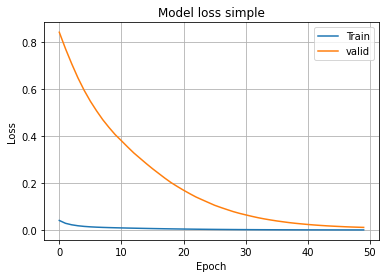

In [68]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss simple')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper right')
plt.grid()
plt.show()


In [69]:
pred1 = model(tf.convert_to_tensor(train_f))

loss on train data =  13.980840585443039


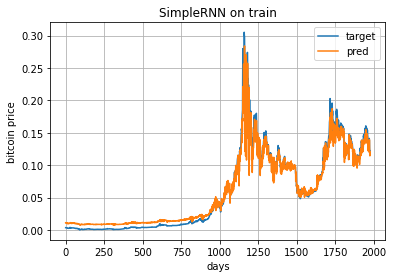

In [70]:
plt.plot(train_t, label='target')
plt.plot(keras.backend.eval(pred1), label='pred')
plt.grid()
plt.xlabel('days')
plt.ylabel('bitcoin price')
plt.title('SimpleRNN on train')
plt.legend()
print('loss on train data = ',np.sum(np.power(pred1- train_t, 2))/len(train_t))

In [72]:
pred2 = model(tf.convert_to_tensor(test_f))

loss on test data =  56.77220419993858


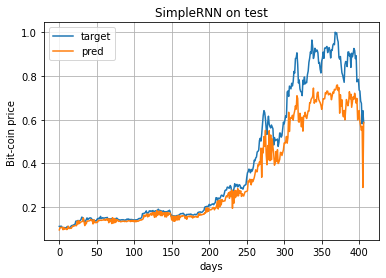

In [73]:
plt.plot(test_t, label='target')
plt.plot(keras.backend.eval(pred2), label='pred')
plt.grid()
plt.xlabel('days')
plt.ylabel('Bit-coin price ')
plt.title('SimpleRNN on test')
plt.legend()
print('loss on test data = ',np.sum(np.power(pred2- test_t, 2))/len(test_t))

###LSTM

In [105]:
model1 = keras.Sequential()
model1.add(LSTM(1))
model1.build(input_shape=(None,wnd_size, n_feature))
model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 1)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [106]:
model1.compile(loss='mse', optimizer='adam')

In [107]:
%%time
history = model1.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=50, batch_size=50)


Epoch 1/50
40/40 [==============================] - 3s 21ms/step - loss: 2.0056e-04 - val_loss: 0.1248
Epoch 2/50
40/40 [==============================] - 0s 10ms/step - loss: 1.6944e-04 - val_loss: 0.1199
Epoch 3/50
40/40 [==============================] - 0s 11ms/step - loss: 1.5672e-04 - val_loss: 0.1142
Epoch 4/50
40/40 [==============================] - 0s 11ms/step - loss: 1.4443e-04 - val_loss: 0.1096
Epoch 5/50
40/40 [==============================] - 0s 10ms/step - loss: 1.3285e-04 - val_loss: 0.1037
Epoch 6/50
40/40 [==============================] - 0s 11ms/step - loss: 1.2385e-04 - val_loss: 0.0992
Epoch 7/50
40/40 [==============================] - 0s 10ms/step - loss: 1.1430e-04 - val_loss: 0.0937
Epoch 8/50
40/40 [==============================] - 0s 10ms/step - loss: 1.0752e-04 - val_loss: 0.0886
Epoch 9/50
40/40 [==============================] - 0s 10ms/step - loss: 9.8631e-05 - val_loss: 0.0839
Epoch 10/50
40/40 [==============================] - 0s 10ms/step - loss:

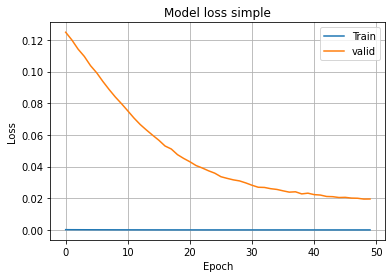

In [108]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss simple')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper right')
plt.grid()
plt.show()

In [109]:
model1.trainable = False
model1.compile(loss='mse', optimizer='adam')

In [110]:
pred3 = model1(tf.convert_to_tensor(train_f))

loss on train data =  15.707234968354431


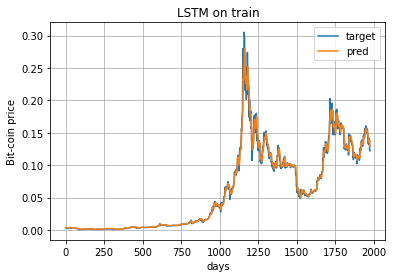

In [111]:
plt.plot(train_t, label='target')
plt.plot(keras.backend.eval(pred3), label='pred')
plt.grid()
plt.xlabel('days')
plt.ylabel('Bit-coin price')
plt.title('LSTM on train')
plt.legend()
print('loss on train data = ',np.sum(np.power(pred3- train_t, 2))/len(train_t))

In [112]:
pred4 = model1(tf.convert_to_tensor(test_f))

loss on test data =  51.70877802518427


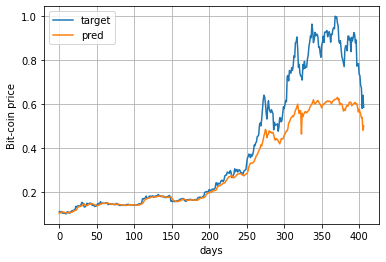

In [113]:
plt.plot(test_t, label='target')
plt.plot(keras.backend.eval(pred4), label='pred')
plt.grid()
plt.xlabel('days')
plt.ylabel('Bit-coin price')
plt.legend()
print('loss on test data = ',np.sum(np.power(pred4- test_t, 2))/len(test_t))

###GRU

In [148]:
model2 = keras.Sequential()
model2.add(GRU(1))
model2.build(input_shape=(None,wnd_size, n_feature))
model2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_23 (ModuleWra (None, 1)                 24        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [149]:
model2.compile(loss='mse', optimizer='adam')

In [150]:
%%time
history = model2.fit(train_f, train_t, validation_data=(test_f, test_t),epochs=50,batch_size=50)


Epoch 1/50
40/40 [==============================] - 3s 23ms/step - loss: 0.0243 - val_loss: 0.7317
Epoch 2/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0160 - val_loss: 0.6282
Epoch 3/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0122 - val_loss: 0.5489
Epoch 4/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0104 - val_loss: 0.4867
Epoch 5/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0093 - val_loss: 0.4381
Epoch 6/50
40/40 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.3961
Epoch 7/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0076 - val_loss: 0.3585
Epoch 8/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0069 - val_loss: 0.3252
Epoch 9/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0062 - val_loss: 0.2930
Epoch 10/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0056 - val_loss: 0.2639
Epoch 11/

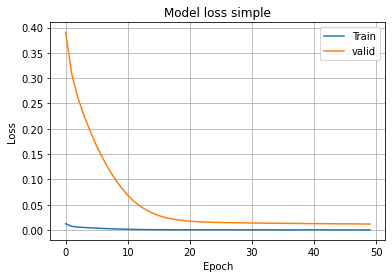

In [120]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss simple')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper right')
plt.grid()
plt.show()

In [121]:
model2.trainable = False
model2.compile(loss='mse', optimizer='adam')

In [122]:
pred5 = model2(tf.convert_to_tensor(train_f))

loss on train data =  15.735869264240506


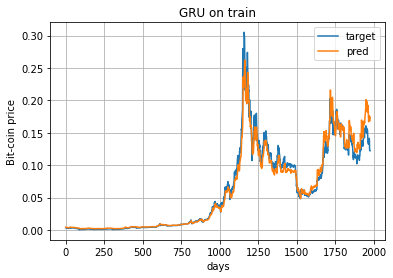

In [123]:
plt.plot(train_t, label='target')
plt.plot(keras.backend.eval(pred5), label='pred')
plt.grid()
plt.xlabel('days')
plt.ylabel('Bit-coin price')
plt.title('GRU on train')
plt.legend()
print('loss on train data = ',np.sum(np.power(pred5- train_t, 2))/len(train_t))

In [124]:
pred6 = model2(tf.convert_to_tensor(test_f))

loss on test data =  53.27689265970516


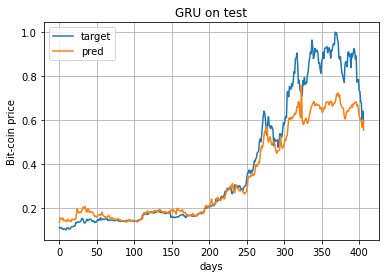

In [125]:
plt.plot(test_t, label='target')
plt.plot(keras.backend.eval(pred6), label='pred')
plt.grid()
plt.xlabel('days')
plt.ylabel('Bit-coin price')
plt.title('GRU on test')
plt.legend()
print('loss on test data = ',np.sum(np.power(pred6- test_t, 2))/len(test_t))

##3. finetune model using different cost function, optimizers and recurrent cells

costs      = [mse , mae]

optimizers = [adam, rmsprop, adagard,SGD]


In [11]:
def make_model(cell, optimizer, cost, wnd_size, n_feature, drop_out = 0):
    model = keras.Sequential()
    model.add(cell(1, input_shape=(wnd_size, n_feature),dropout=drop_out, recurrent_dropout=drop_out))
    model.compile(loss=cost, optimizer=optimizer)
    return model

def plot_loss(cell_name, optimizer, cost, history, desc=''):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(desc+f'{cell_name}, {optimizer}, {cost}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'valid'], loc='upper left')
    plt.grid()
    plt.show()

def plot_performance(cell_name, optimizer, cost, model, train_f, train_t, test_f, test_t, desc=''):
    # model.trainable = False
    # model.compile(loss=cost, optimizer=optimizer)

    plt.figure(figsize=(17, 7))
    
    plt.subplot(1, 2, 1)
    # train
    pred = keras.backend.eval(model(tf.convert_to_tensor(train_f)))
    plt.plot(train_t, label='target')
    plt.plot(pred, label='pred')
    plt.grid()
    plt.xlabel('h')
    plt.ylabel('pollution')
    plt.title(desc+f'{cell_name}, {optimizer}, {cost} on train')
    plt.legend()

    print(f'mse on train: {np.sum(np.power(pred- train_t, 2))/len(train_t)}')

    plt.subplot(1, 2, 2)
    # test
    pred = keras.backend.eval(model(tf.convert_to_tensor(test_f)))
    plt.plot(test_t, label='target')
    plt.plot(pred, label='pred')
    plt.grid()
    plt.xlabel('h')
    plt.ylabel('pollution')
    plt.title(f'{cell_name}, {optimizer}, {cost} on test')
    plt.legend()
    print(f'mse on test: {np.sum(np.power(pred- test_t, 2))/len(test_t)}')
    plt.show()


In [12]:
optimizers = ['adam', 'rmsprop', 'adagrad','SGD']
costs = ['mse','mae']

### costs

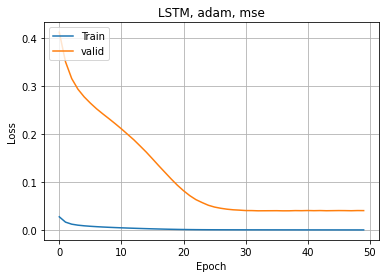

mse on train: 15.569024869671034
mse on test: 46.163562457399


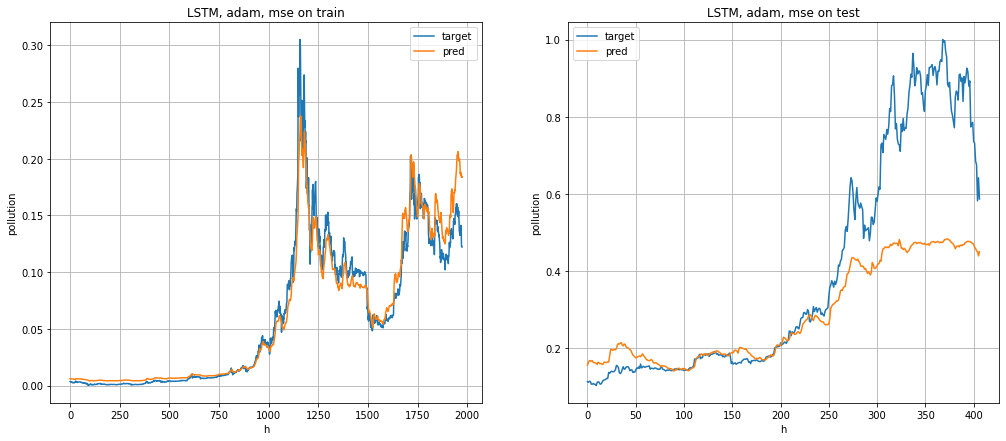

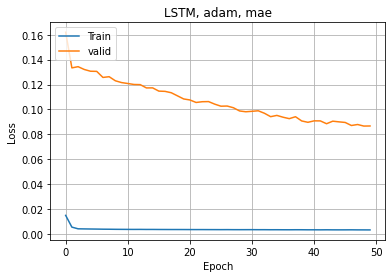

mse on train: 15.60196062815198
mse on test: 51.344545057460394


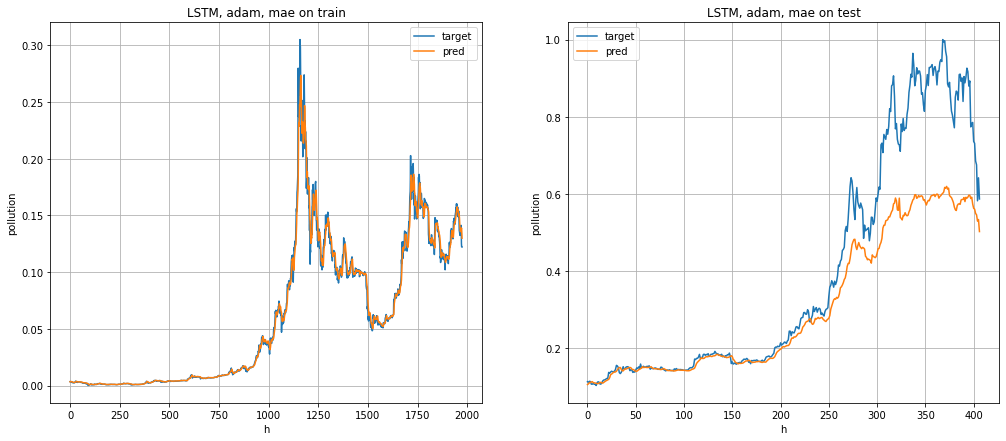

In [15]:
epochs = 50
batch_size = 50
cell = LSTM
optimizer = 'adam'
for cost in costs:
    model = make_model(cell, optimizer, cost, wnd_size, 5)
    history = model.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=epochs, batch_size=batch_size, verbose=0)
    plot_loss('LSTM', optimizer, cost, history)
    plot_performance('LSTM', optimizer, cost, model, train_f, train_t, test_f, test_t)

###optimizers


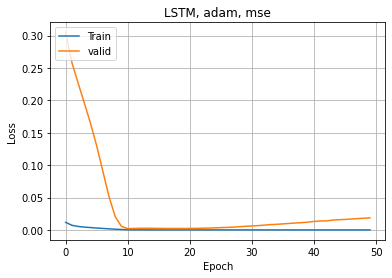

mse on train: 15.680975286724898
mse on test: 51.89294615871266


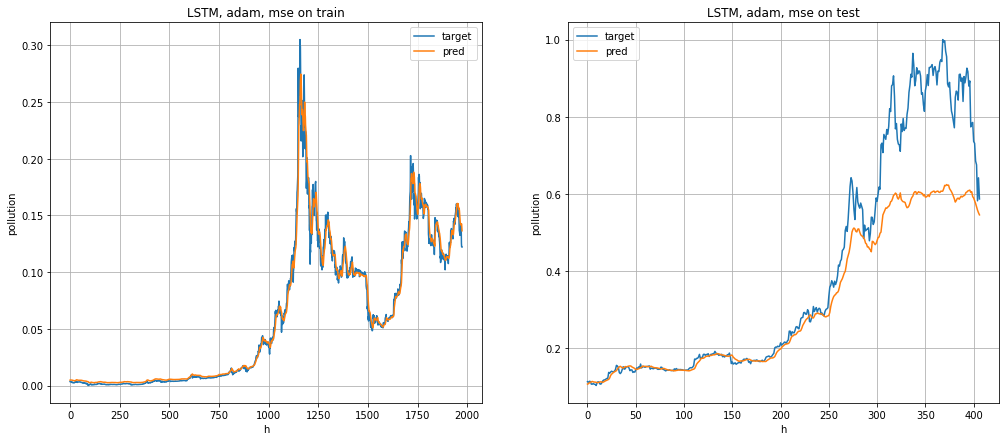

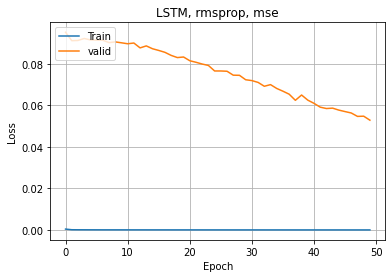

mse on train: 15.785097861454531
mse on test: 47.543979616824046


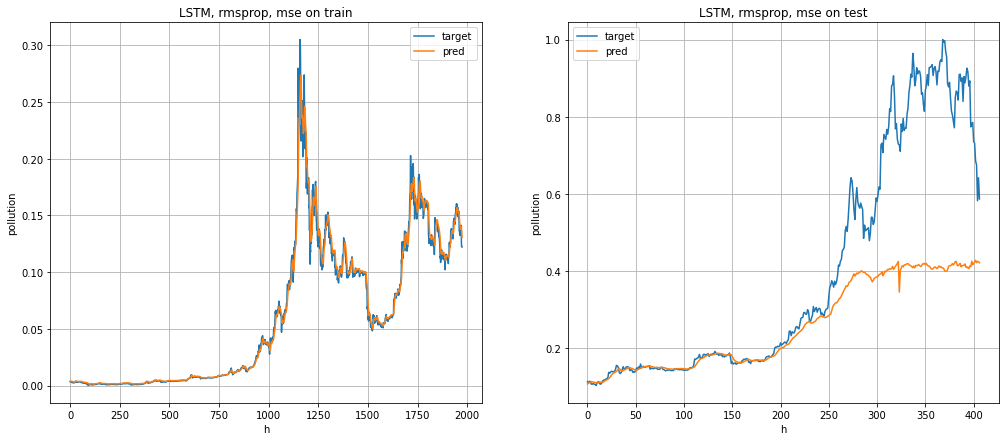

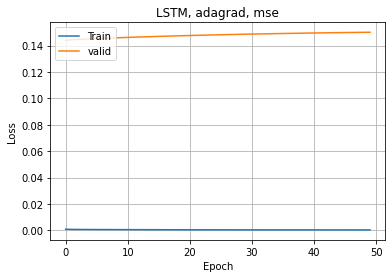

mse on train: 16.542798048515817
mse on test: 60.98483082419969


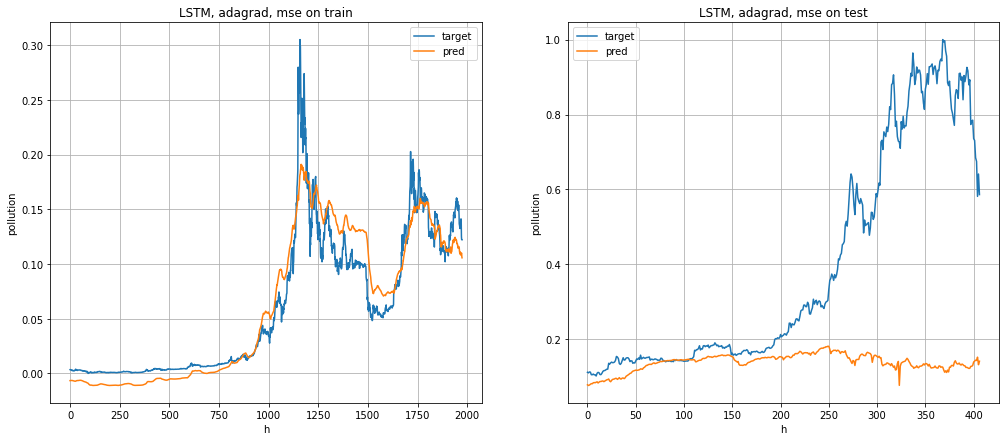

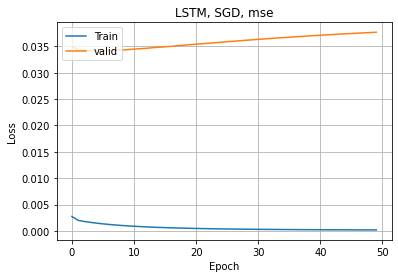

mse on train: 17.368072299561984
mse on test: 45.68162571446252


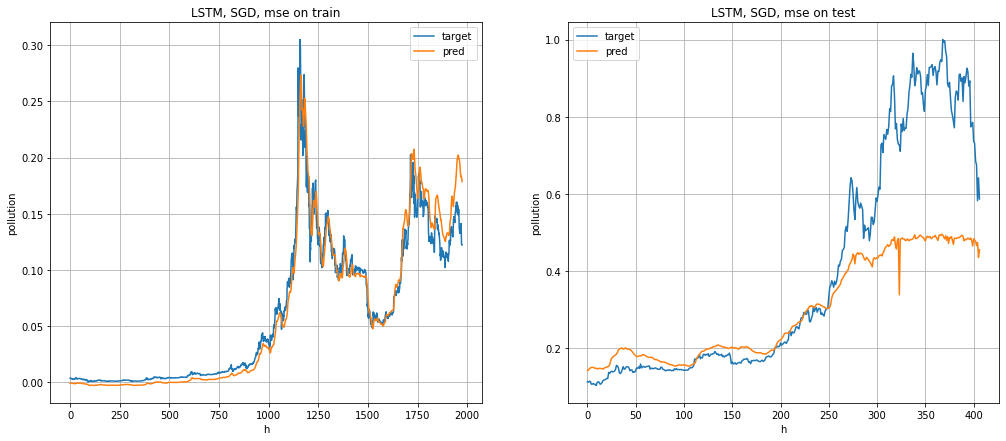

In [17]:
epochs = 50
batch_size = 50
cell = LSTM
cost = 'mse'
for optimizer in optimizers:
    model = make_model(cell, optimizer, cost, wnd_size, 5)
    history = model.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=epochs, batch_size=batch_size, verbose=0)
    plot_loss('LSTM', optimizer, cost, history)
    plot_performance('LSTM', optimizer, cost, model, train_f, train_t, test_f, test_t)

##4. drop out effect

###GRU

Epoch 1/50
40/40 [==============================] - 3s 25ms/step - loss: 0.0188 - val_loss: 0.5816
Epoch 2/50
40/40 [==============================] - 1s 16ms/step - loss: 0.0123 - val_loss: 0.4746
Epoch 3/50
40/40 [==============================] - 1s 16ms/step - loss: 0.0101 - val_loss: 0.3992
Epoch 4/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0088 - val_loss: 0.3474
Epoch 5/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0072 - val_loss: 0.3083
Epoch 6/50
40/40 [==============================] - 1s 16ms/step - loss: 0.0068 - val_loss: 0.2707
Epoch 7/50
40/40 [==============================] - 1s 16ms/step - loss: 0.0061 - val_loss: 0.2388
Epoch 8/50
40/40 [==============================] - 1s 16ms/step - loss: 0.0055 - val_loss: 0.2108
Epoch 9/50
40/40 [==============================] - 1s 16ms/step - loss: 0.0047 - val_loss: 0.1852
Epoch 10/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.1634
Epoch 11/

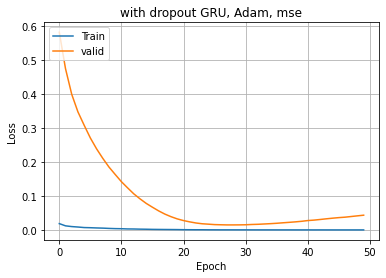

mse on train: 15.318016918210647
mse on test: 47.83191741774212


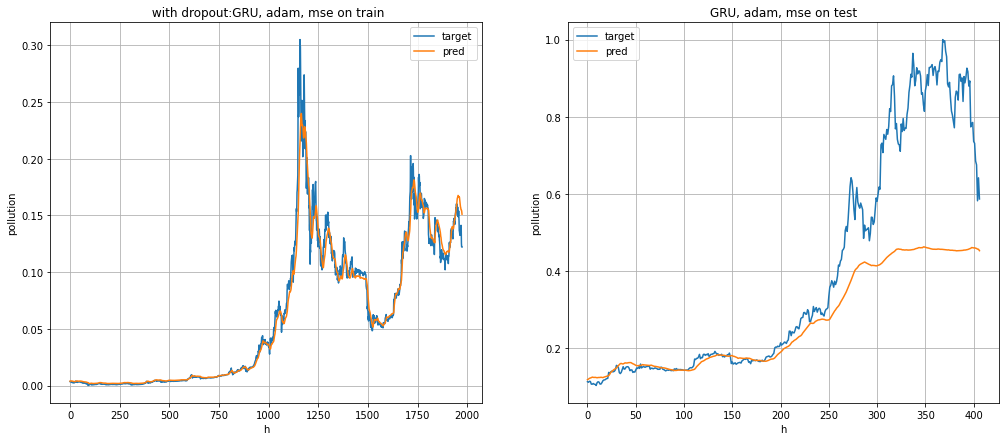

In [202]:
drop_model = make_model(GRU, 'Adam', 'mse', 25, 5, drop_out=0.3)
drop_history = drop_model.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=50, batch_size=50)
plot_loss('GRU', 'Adam', 'mse', drop_history, 'with dropout ')
plot_performance('GRU', 'adam', 'mse', drop_model, train_f, train_t, test_f,  test_t, desc=' with dropout:')

###LSTM

Epoch 1/50
40/40 [==============================] - 3s 27ms/step - loss: 0.0167 - val_loss: 0.4021
Epoch 2/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0117 - val_loss: 0.3477
Epoch 3/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0092 - val_loss: 0.3131
Epoch 4/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0075 - val_loss: 0.2869
Epoch 5/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0065 - val_loss: 0.2671
Epoch 6/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0059 - val_loss: 0.2498
Epoch 7/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0055 - val_loss: 0.2330
Epoch 8/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.2177
Epoch 9/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0045 - val_loss: 0.2015
Epoch 10/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.1853
Epoch 11/

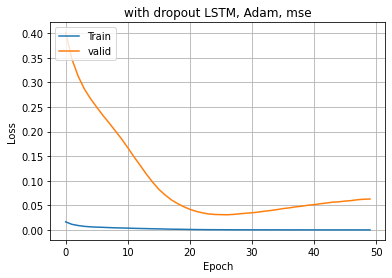

mse on train: 15.503160404145888
mse on test: 46.74707841492215


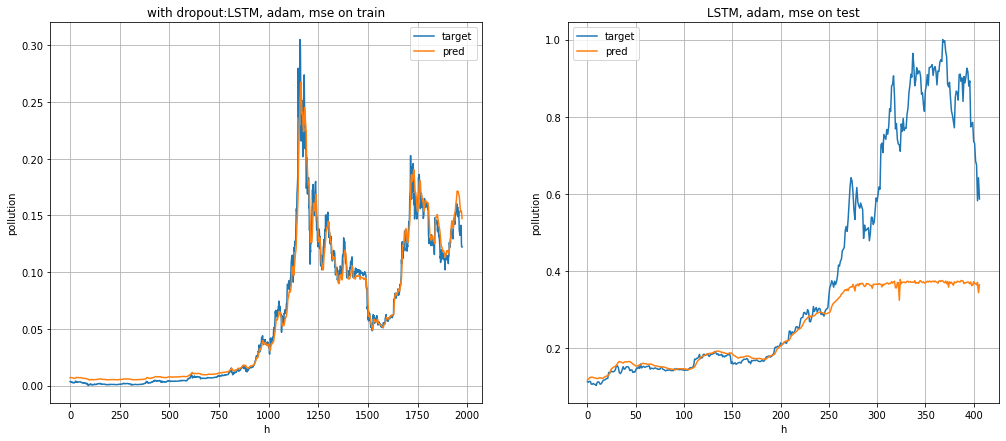

In [201]:
drop_model = make_model(LSTM, 'Adam', 'mse', 25, 5, drop_out=0.3)
drop_history = drop_model.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=50, batch_size=50)
plot_loss('LSTM', 'Adam', 'mse', drop_history, 'with dropout ')
plot_performance('LSTM', 'adam', 'mse', drop_model, train_f, train_t, test_f, test_t, desc='with dropout:')

###RNN

Epoch 1/50
40/40 [==============================] - 1s 12ms/step - loss: 0.0814 - val_loss: 0.6408
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0709 - val_loss: 0.6028
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0627 - val_loss: 0.5631
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0490 - val_loss: 0.5245
Epoch 5/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0383 - val_loss: 0.4923
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0333 - val_loss: 0.4653
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0299 - val_loss: 0.4382
Epoch 8/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0264 - val_loss: 0.4141
Epoch 9/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0233 - val_loss: 0.3889
Epoch 10/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0214 - val_loss: 0.3665
Epoch 11/50
40/40 

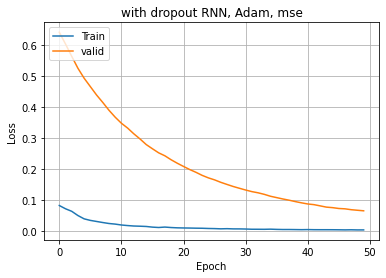

mse on train: 9.911182241544111
mse on test: 54.98388425672029


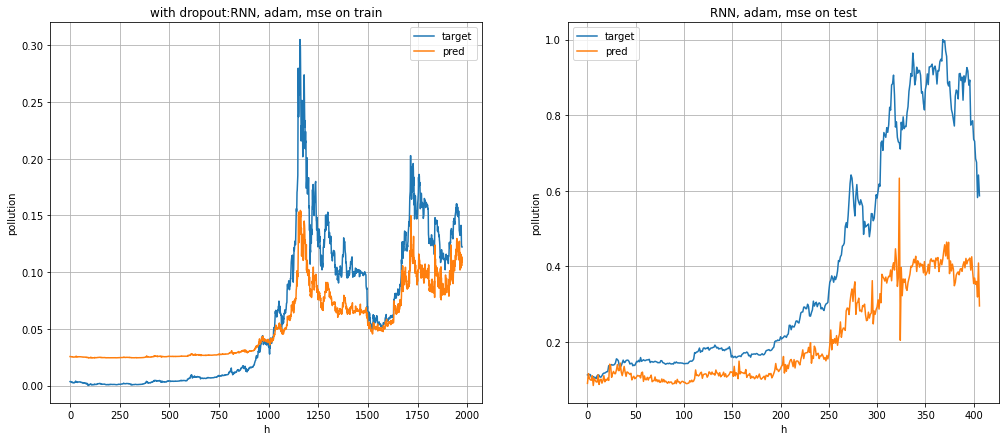

In [205]:
drop_model = make_model(SimpleRNN, 'Adam', 'mse', 25, 5, drop_out=0.3)
drop_history = drop_model.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=50, batch_size=50)
plot_loss('RNN', 'Adam', 'mse', drop_history, 'with dropout ')
plot_performance('RNN', 'adam', 'mse', drop_model, train_f, train_t, test_f, test_t, desc='with dropout:')

##5. MLP classifier

In [18]:
mlp_data = train_f.copy()
mlp_data = mlp_data.reshape((len(train_f),125))
train_f.shape,mlp_data.shape

((1975, 25, 5), (1975, 125))

In [19]:
mlp_test = test_f.copy()
mlp_test = mlp_test.reshape((len(test_f),125))
test_f.shape,mlp_test.shape

((407, 25, 5), (407, 125))

In [20]:

input_shape = (125,)
model_mlp = Sequential()
model_mlp.add(Dense(200, input_shape=input_shape, activation='relu'))
model_mlp.add(Dense(50, activation='relu'))
model_mlp.add(Dense(1, activation='sigmoid'))
model_mlp.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               25200     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 35,301
Trainable params: 35,301
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Configure the model and start training
model_mlp.compile(loss='mse', optimizer='adam')
history_mlp = model_mlp.fit(mlp_data, train_t, validation_data=(mlp_test, test_t), epochs=50, batch_size=50)


Epoch 1/50
40/40 [==============================] - 14s 13ms/step - loss: 0.1286 - val_loss: 0.2379
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.2379
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.2379
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.2379
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.2379
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.2379
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.2379
Epoch 8/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.2379
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.2379
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.2379
Epoch 11/50
40/40

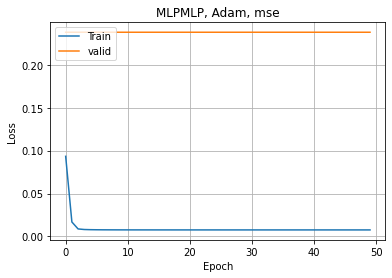

mse on train: 14.737798702426653
mse on test: 96.84447039161454


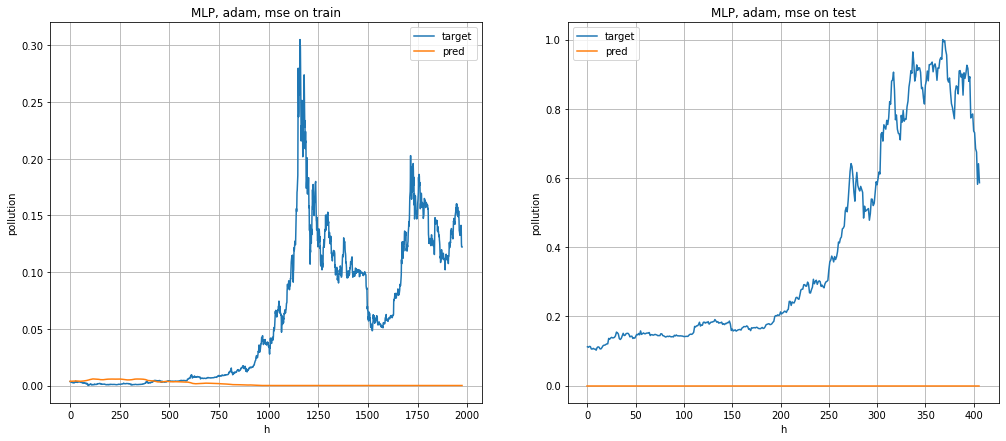

In [22]:
plot_loss('MLP', 'Adam', 'mse', history_mlp, 'MLP')
plot_performance('MLP', 'adam', 'mse', model_mlp, mlp_data, train_t, mlp_test, test_t,)

##7. add more recurrent layar

In [235]:
input_shape = (25,5)
model_2rc = Sequential()
model_2rc.add(LSTM(20, input_shape=input_shape,return_sequences=True))
model_2rc.add(GRU(1))

model_2rc.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 25, 20)            2080      
_________________________________________________________________
gru_28 (GRU)                 (None, 1)                 69        
Total params: 2,149
Trainable params: 2,149
Non-trainable params: 0
_________________________________________________________________


In [236]:
model_2rc.compile(loss='mse', optimizer='adam')
history_2rc = model_2rc.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=50, batch_size=50)


Epoch 1/50
40/40 [==============================] - 6s 46ms/step - loss: 0.0037 - val_loss: 0.0221
Epoch 2/50
40/40 [==============================] - 1s 22ms/step - loss: 1.5253e-04 - val_loss: 0.0248
Epoch 3/50
40/40 [==============================] - 1s 24ms/step - loss: 1.2843e-04 - val_loss: 0.0244
Epoch 4/50
40/40 [==============================] - 1s 23ms/step - loss: 1.3172e-04 - val_loss: 0.0280
Epoch 5/50
40/40 [==============================] - 1s 23ms/step - loss: 1.0581e-04 - val_loss: 0.0263
Epoch 6/50
40/40 [==============================] - 1s 23ms/step - loss: 1.0098e-04 - val_loss: 0.0255
Epoch 7/50
40/40 [==============================] - 1s 22ms/step - loss: 1.4921e-04 - val_loss: 0.0254
Epoch 8/50
40/40 [==============================] - 1s 23ms/step - loss: 1.0391e-04 - val_loss: 0.0259
Epoch 9/50
40/40 [==============================] - 1s 24ms/step - loss: 9.1918e-05 - val_loss: 0.0253
Epoch 10/50
40/40 [==============================] - 1s 23ms/step - loss: 1.0

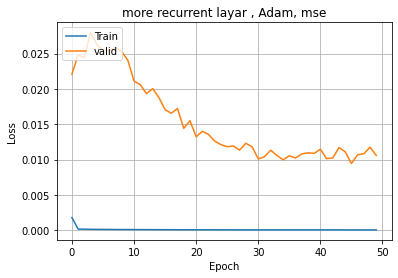

mse on train: 15.784725572171874
mse on test: 55.47897377184306


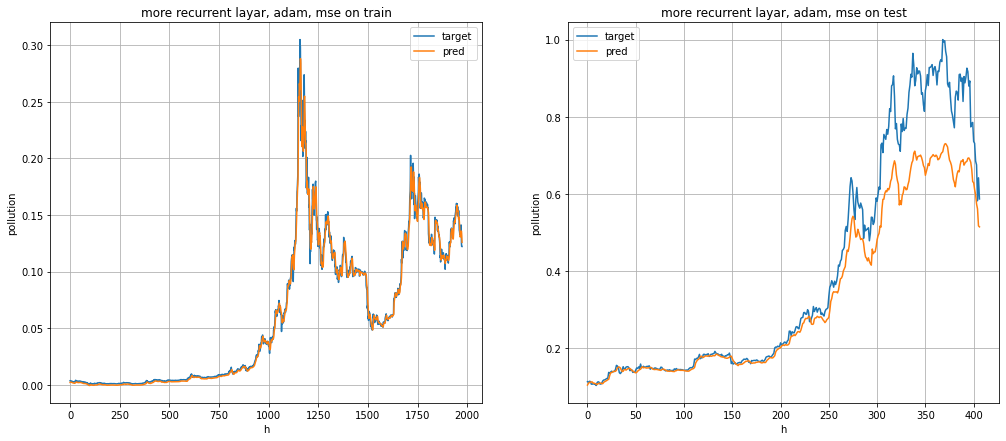

In [256]:
plot_loss(' ', 'Adam', 'mse', history_2rc, 'more recurrent layar')
plot_performance('more recurrent layar', 'adam', 'mse', model_2rc, train_f, train_t, test_f, test_t,)

##9. convolutional 

In [381]:
model_con = models.Sequential()
model_con.add(layers.ConvLSTM2D(32, 3,data_format='channels_last' , activation='relu', input_shape=(1,25, 5,1)))

model_con.summary()

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_21 (ConvLSTM2D) (None, 23, 3, 32)         38144     
Total params: 38,144
Trainable params: 38,144
Non-trainable params: 0
_________________________________________________________________


In [385]:
a =np.array( [[ [ [[c] for c in x] for x in y ]] for y in train_f])
a.shape


(1975, 1, 25, 5, 1)

In [384]:
b =np.array( [ [ [[[c] for c in x] for x in y ]] for y in test_f])
b.shape

(407, 1, 25, 5, 1)

In [ ]:
model_con.compile(loss='mse', optimizer='adam')
history_con = model_con.fit(a, train_t, validation_data=(b, test_t), epochs=50, batch_size=50)

##10. transform


In [410]:
start = datetime.datetime(2014, 9, 20)
end = datetime.datetime(2021, 5, 20)
df_2 = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
df_2.head()
df_3 = df_2.copy()
df_4 = df_2.copy()


###standard

In [396]:
from sklearn.preprocessing import StandardScaler

In [403]:
scaler = StandardScaler()
df_2 = scaler.fit_transform(df_2)
data2 = np.array(df_2)[:,1:]
data2_train = data2[:2000]
data2_test = data2[2000:]
wnd_size = 25
smpl = 1
train2_f, train2_t = make_seq(data2_train, wnd_size, smpl)
test2_f, test2_t  = make_seq(data2_test, wnd_size, smpl)
train2_f.shape, train2_t.shape, test2_f.shape, test2_t.shape

((1975, 25, 5), (1975,), (407, 25, 5), (407,))

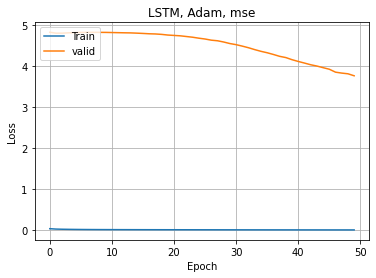

mse on train: 461.51393122992516
mse on test: 1671.7616813312093


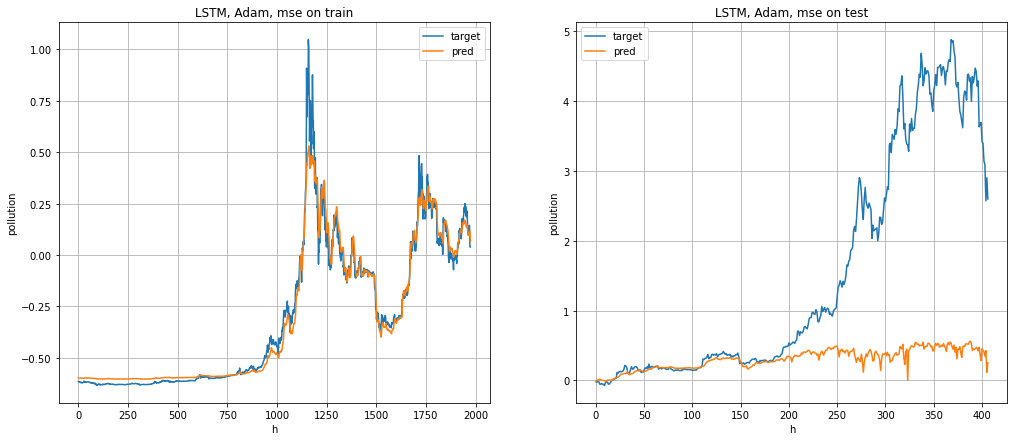

In [428]:
epochs = 50
batch_size = 50
optimizer = 'Adam'
cost = 'mse'
model = make_model(LSTM, 'Adam', 'mse', wnd_size, n_feature)
history = model.fit(train2_f, train2_t, validation_data=(test2_f, test2_t), epochs=epochs, batch_size=batch_size, verbose=0)
plot_loss('LSTM', optimizer, cost, history)
plot_performance('LSTM', optimizer, cost, model, train2_f, train2_t, test2_f, test2_t)

###normalize

In [399]:
from sklearn.preprocessing import normalize

In [406]:
# scaler = normalize()
# df_3 = scaler.fit_transform(df_2)
df_3 = normalize(df_3)
data3 = np.array(df_3)[:,1:]
data3_train = data3[:2000]
data3_test = data3[2000:]
wnd_size = 25
smpl = 1
train3_f, train3_t = make_seq(data3_train, wnd_size, smpl)
test3_f, test3_t  = make_seq(data3_test, wnd_size, smpl)
train3_f.shape, train3_t.shape, test3_f.shape, test3_t.shape

((1975, 25, 5), (1975,), (407, 25, 5), (407,))

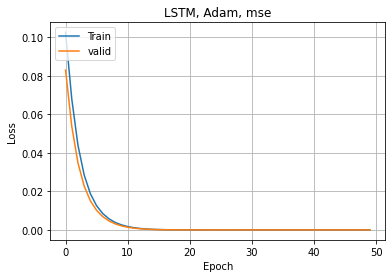

mse on train: 8.459626485437008e-08
mse on test: 1.4951978707864276e-08


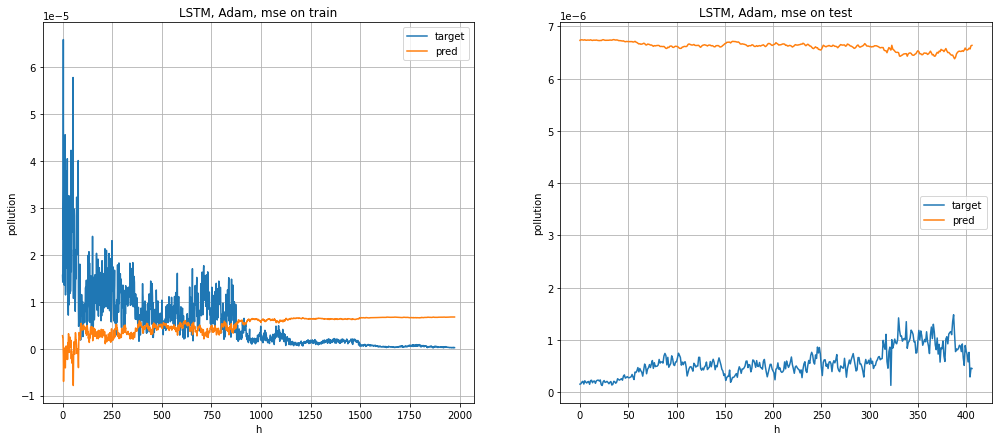

In [429]:
epochs = 50
batch_size = 50
optimizer = 'Adam'
cost = 'mse'
model = make_model(LSTM, 'Adam', 'mse', wnd_size, n_feature)
history = model.fit(train3_f, train3_t, validation_data=(test3_f, test3_t), epochs=epochs, batch_size=batch_size, verbose=0)
plot_loss('LSTM', optimizer, cost, history)
plot_performance('LSTM', optimizer, cost, model, train3_f, train3_t, test3_f, test3_t)

###power transform

In [408]:
from sklearn.preprocessing import PowerTransformer

In [425]:
scaler = PowerTransformer()
df_4 = scaler.fit_transform(df_4)
data4 = np.array(df_4)[:,1:]
data4_train = data4[:2000]
data4_test = data4[2000:]
wnd_size = 25
smpl = 1
train4_f, train4_t = make_seq(data4_train, wnd_size, smpl)
test4_f, test4_t  = make_seq(data4_test, wnd_size, smpl)
train4_f.shape, train4_t.shape, test4_f.shape, test4_t.shape

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


((1975, 25, 5), (1975,), (407, 25, 5), (407,))

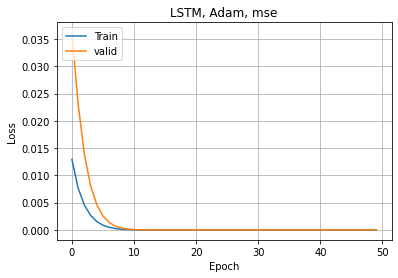

mse on train: 4.4077120910118804e-43
mse on test: 5.475437182646869e-43


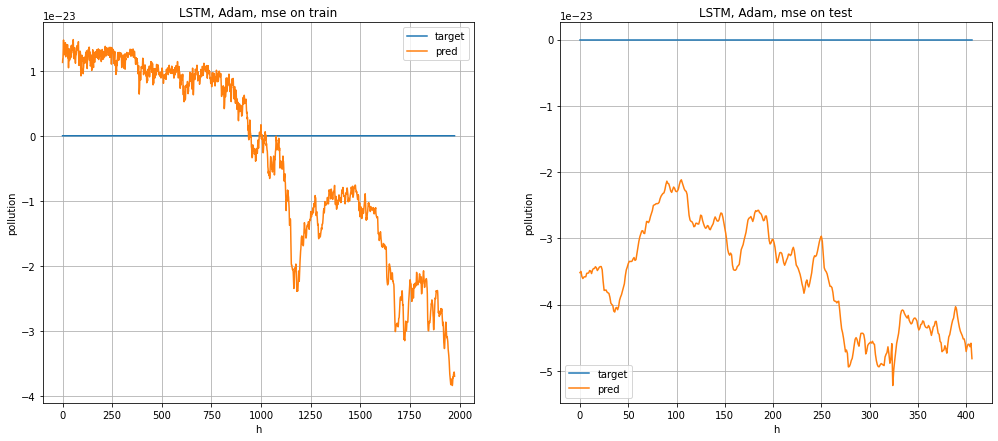

In [430]:
epochs = 50
batch_size = 50
optimizer = 'Adam'
cost = 'mse'
model = make_model(LSTM, 'Adam', 'mse', wnd_size, n_feature)
history = model.fit(train4_f, train4_t, validation_data=(test4_f, test4_t), epochs=epochs, batch_size=batch_size, verbose=0)
plot_loss('LSTM', optimizer, cost, history)
plot_performance('LSTM', optimizer, cost, model, train4_f, train4_t, test4_f, test4_t)

##11. prediction

In [446]:
epochs = 50
batch_size = 50
optimizer = 'Adam'
cost = 'mse'

input_shape = (25,5)
model_f = Sequential()
model_f.add(LSTM(5, input_shape=input_shape))
model_f.summary()
model_f.compile(loss='mse', optimizer='adam')
history_f = model_2rc.fit(train_f, train_t, validation_data=(test_f, test_t), epochs=50, batch_size=50)


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 5)                 220       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40/40 [==============================] - 1s 23ms/step - loss: 2.3512e-05 - val_loss: 0.0118
Epoch 2/50
40/40 [==============================] - 1s 22ms/step - loss: 2.4649e-05 - val_loss: 0.0117
Epoch 3/50
40/40 [==============================] - 1s 23ms/step - loss: 2.2611e-05 - val_loss: 0.0122
Epoch 4/50
40/40 [==============================] - 1s 23ms/step - loss: 2.2723e-05 - val_loss: 0.0125
Epoch 5/50
40/40 [==============================] - 1s 22ms/step - loss: 2.4461e-05 - val_loss: 0.0115
Epoch 6/50
40/40 [==============================] - 1s 22ms/step - loss: 2.2335e-05 - val_loss: 0.0122
Epoch 7/50
40/40 [=============

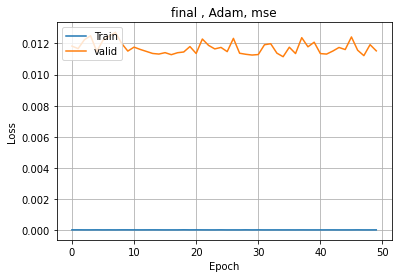

In [447]:
plot_loss(' ', 'Adam', 'mse', history_f, 'final')

In [512]:
d1 = np.array([test_f[0]])
day1 = model_f.predict(d1)
print(np.sum(np.power(day1- train_t[0], 2))/5)
d2 = np.concatenate((d1,np.array([day1])),axis=1) 
d2 = d2[:,1:,:]
day2 = model_f.predict(d2)
print(np.sum(np.power(day2- train_t[2], 2))/5)
d3 = np.concatenate((d2,np.array([day2])),axis=1) 
d3 = d3[:,1:,:]
day3 = model_f.predict(d3)
print(np.sum(np.power(day3- train_t[3], 2))/5)
d4 = np.concatenate((d3,np.array([day3])),axis=1) 
d4 = d4[:,1:,:]
day4 = model_f.predict(d4)
print(np.sum(np.power(day4- train_t[3], 2))/5)
d5 = np.concatenate((d4,np.array([day4])),axis=1) 
d5 = d5[:,1:,:]
day5 = model_f.predict(d5)
print(np.sum(np.power(day5- train_t[4], 2))/5)
d6 = np.concatenate((d5,np.array([day5])),axis=1) 
d6 = d6[:,1:,:]
day6 = model_f.predict(d6)
print(np.sum(np.power(day6- train_t[5], 2))/5)
d7 = np.concatenate((d6,np.array([day6])),axis=1) 
d7 = d7[:,1:,:]
day7 = model_f.predict(d7)
print(np.sum(np.power(day7- train_t[6], 2))/5)

0.0102597676217556
0.0060183446854352955
0.0037279609590768815
0.0023321740329265593
0.0014423553831875325
0.000876697339117527
0.0005319054704159498
